# Interpolation 02 test

## lagrange_poly

In [1]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file_name: interpolation_entity_utils.py
@IDE: PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import numpy as np  # 数值计算
import sympy  # 符号计算
import matplotlib as plt
from util_font import *


class InterpolationUtils:
    """
    多项式插值工具类，封装插值多项式的类属性以及常见工具实例方法
    """
    # 类属性变量：
    polynomial, poly_degree = None, None  # 插值多项式和多项式系数最高阶
    poly_coefficient, coefficient_order = None, None  # 多项式系数和各系数阶次

    def __init__(self, x, y):
        """
        多项式插值必要参数初始化，及各健壮性条件测试
        :param x: 已知自变量数据，格式可为列表、ndarray
        :param y: 已知因变量数据，格式可为列表、ndarray
        """
        self.x = np.asarray(x, dtype=np.float64)  # 显式转换为ndarray
        self.y = np.asarray(y, dtype=np.float64)  # 显式转换为ndarray
        if len(self.x) < 2 or len(self.x) != len(self.y):
            raise ValueError("数据(xi,yi)的维度不匹配或插值节点数量过少。")
        self.n = len(x)  # 已知数据节点的数量

    def interpolation_polynomial(self, t):
        """
        插值多项式的特征项
        :return:
        """
        if self.polynomial:
            self.polynomial = sympy.expand(self.polynomial)  # 多项式展开
            polynomial = sympy.Poly(self.polynomial, t)  # 生成多项式对象
            self.poly_coefficient = polynomial.coeffs()  # 获取多项式的系数
            self.poly_degree = polynomial.degree()  # 获得多项式的最高阶次
            self.coefficient_order = polynomial.monoms()  # 多项式的阶次
        else:
            print("插值多项式的类属性polynomial为None.")
            exit(0)

    def predict_x0(self, x0):
        """
        预测，通过离散插值点生成的插值多项式（符号多项式），计算插值点x0的插值
        :param x0: 所求插值点，结构可为元组、列表或ndarray对象
        :return:
        """
        x0 = np.asarray(x0, dtype=np.float64)  # 显示转化为ndarray
        if self.polynomial:
            t = self.polynomial.free_symbols.pop()  # 获取插值多项式的自由符号变量
            # 转换为lambda函数，并进行数值计算
            lambda_f = sympy.lambdify(t, self.polynomial, "numpy")
            return lambda_f(x0)
        else:
            return None

    def plt_interpolation(self, params, fh=None):
        """
        可视化插值多项式，以及插值点
        :param params: 可视化必要参数信息元组
        :param fh: 模拟函数
        :return:
        """
        title_info, x0, y0, is_show = params  # 解包
        if is_show:  # 用于子图绘制，如果当前图形绘制为一子图，则is_show设置为False
            plt.figure(figsize=(7, 5))

        xi = np.linspace(min(self.x), max(self.x), 200)  # 插值区间内等分150个离散插值节点
        yi_hat = self.predict_x0(xi)  # 求等分点的插值
        plt.plot(xi, yi_hat, "k-", label="$g(x)$曲线")  # 可视化插值多项式
        if x0 is not None and y0 is not None:
            plt.plot(x0, y0, "bs", markersize=6, label="$(x_0, \hat y_0)$")  # 可视化所求插值点
        mse = 0.0  # 均方误差
        if fh is not None:
            plt.plot(xi, fh(xi), "r--", label="$f(x)$曲线")  # 真实函数曲线
            mse = np.mean((fh(xi) - yi_hat) ** 2)  # 均方误差
        plt.plot(self.x, self.y, "ro", label="$(x_i,y_i)$")  # 离散插值节点
        plt.legend(frameon=False, fontsize=16)  # 添加图例，并取消外方框
        plt.grid(ls=":")  # 添加主要网格线，且是虚线
        plt.xlabel("$x$", fontdict={"fontsize": 18})  # 横坐标标记，latex修饰
        plt.ylabel("$f(x) \ /\  g(x)$", fontdict={"fontsize": 18})  # 纵坐标标记，latex修饰
        plt.tick_params(labelsize=16)  # 刻度字体大小16
        if mse != 0.0:
            plt.title(title_info + "插值多项式：$MSE=%.5e$" % mse, fontdict={"fontsize": 18})  # 标题
        else:
            plt.title(title_info + "插值多项式曲线及插值节点", fontdict={"fontsize": 18})  # 标题
        if is_show:
            plt.show()

    def check_equidistant(self):
        """
        判断数据节点x是否是等距节点. 若等距, 返回等距步长h
        :return:
        """
        if self.n < 2:
            raise ValueError("插值节点数量最少为2个。。。")
        xx = np.linspace(min(self.x), max(self.x), self.n, endpoint=True)
        if (self.x == xx).all() or (self.x == xx[::-1]).all():  # 升序或降序
            return self.x[1] - self.x[0]  # 等距步长
        else:
            raise ValueError("非等距节点，不可使用此算法。")

    def cal_difference(self, diff_method="forward"):
        """
        计算牛顿差分：向前差分forward，向后差分backward
        :return:
        """
        self.check_equidistant()  # 首先判断是否等距节点
        diff_val = np.zeros((self.n, self.n))  # 差分表
        diff_val[:, 0] = self.y  # 第1列存储离散数据值
        if diff_method == "forward":  # 前向差分
            for j in range(1, self.n):
                i = np.arange(0, self.n - j)
                diff_val[i, j] = diff_val[i + 1, j - 1] - diff_val[i, j - 1]
        elif diff_method == "backward":  # 后向差分
            for j in range(1, self.n):
                i = np.arange(j, self.n)
                diff_val[i, j] = diff_val[i, j - 1] - diff_val[i - 1, j - 1]
        else:
            raise AttributeError("仅支持forward、backward两种差分.")
        return diff_val


In [2]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file:lagrange_interpolation.py
@IDE: PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""

import sympy  # 符号运算库
# 导入插值多项式工具类
from interpolation_02.utils.interpolation_utils import InterpolationUtils


class LagrangeInterpolation(InterpolationUtils):
    """
    拉格朗日插值多项式算法类，共包含三个实例方法，且继承InterpolationUtils
    """

    def __init__(self, x, y):
        InterpolationUtils.__init__(self, x, y)  # 调用父类进行参数初始化
        self.interp_base_fun = []  # 拉格朗日独有的实例属性，存储插值基函数

    def fit_interp(self):
        """
        根据已知插值点，生成拉格朗日插值多项式算法，核心即构造插值基函数
        :return: 插值多项式polynomial符号显示
        """
        t = sympy.Symbol("t")  # 定义符号变量
        self.polynomial = 0.0  # 插值多项式实例化
        for i in range(self.n):  # 针对每个数据点
            base_fun = 1.0  # 插值基函数计算，要求i != j
            for j in range(i):
                base_fun = base_fun * (t - self.x[j]) / (self.x[i] - self.x[j])
            for j in range(i + 1, self.n):
                base_fun = base_fun * (t - self.x[j]) / (self.x[i] - self.x[j])
            self.interp_base_fun.append(sympy.expand(base_fun))  # 存储插值基函数
            self.polynomial += base_fun * self.y[i]  # 插值多项式求和
        # 插值多项式的特征项
        InterpolationUtils.interpolation_polynomial(self, t)  # 调用父类

    def plt_interpolation(self, x0=None, y0=None, fh=None, is_show=True):
        """
        可视化插值多项式和插值点
        """
        params = "$Lagrange$", x0, y0, is_show  # 构成元组，封包
        InterpolationUtils.plt_interpolation(self, params, fh)  # 调用父类方法


拉格朗日插值多项式：
 -6.66133814775094e-16*t**9 + 1.4210854715202e-14*t**8 - 4.2632564145606e-14*t**7 - 0.300000000000011*t**6 + 0.499999999999964*t**5 - 1.00000000000001*t**4 + 1.80000000000003*t**3 - 3.6*t**2 + 4.49999999999999*t + 2.0
多项式系数： [-6.66133814775094e-16, 1.42108547152020e-14, -4.26325641456060e-14, -0.300000000000011, 0.499999999999964, -1.00000000000001, 1.80000000000003, -3.60000000000000, 4.49999999999999, 2.00000000000000]
多项式系数对应的各阶次： [(9,), (8,), (7,), (6,), (5,), (4,), (3,), (2,), (1,), (0,)]
-7.388977
0.939821
2.042187
-18.029011
-74.290312
-117.945151
插值点x0的多项式插值： [  -7.3889773    0.9398208    2.0421875  -18.0290112  -74.2903117
 -117.9451513] ，误差： [-2.13162821e-14 -1.55431223e-15  7.52287121e-13  6.67910172e-12
  1.89146476e-11  2.60627075e-11]
离散数据点(xk, yk)对应的多项式插值
 [-9.70000000e+00 -2.05029439e+00  1.45292497e+00  3.15596708e+00
  3.87908630e+00  3.54077743e+00  1.17283951e-01 -1.30626807e+01
 -5.16879987e+01 -1.46500000e+02]
离散数据点x插值的误差：
 [-5.15143483e-14 -1.77635684e

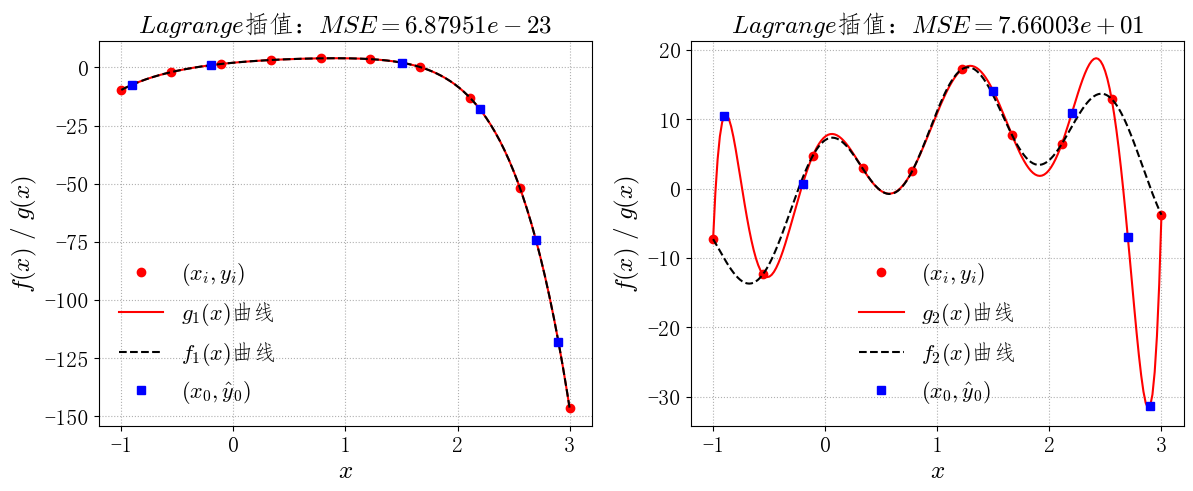

多项式系数： [5.21967726281006, -45.4481073886596, 130.916158749739, -93.9372681559393, -173.414352335548, 244.306018629341, 33.6895559534289, -110.592454789985, 12.6976757331614, 7.50998153418927]
多项式系数对应的各阶次： [(9,), (8,), (7,), (6,), (5,), (4,), (3,), (2,), (1,), (0,)]
插值点x0的多项式插值： [ 10.50607992   0.71580724  14.05746084  10.86792416  -6.97195973
 -31.30065605] ，误差： [-20.59824652   0.88094626  -0.65856877  -1.94348383  15.83758306
  31.44792881]
离散数据点(xk, yk)对应的多项式插值
 [ -7.27054553 -12.34339218   4.72754403   2.92907683   2.58397236
  17.23508974   7.72105926   6.45131988  12.92785726  -3.7654953 ]
离散数据点x插值的误差：
 [ 7.50510765e-13  5.86197757e-14  0.00000000e+00  8.88178420e-15
 -1.33226763e-14 -1.03383968e-12 -9.11626330e-12 -3.82138765e-11
 -1.36976652e-10 -3.80925513e-10]
[-0.00407267383166722*t**9 + 0.0447994121483394*t**8 - 0.194884984833854*t**7 + 0.418127846717834*t**6 - 0.431398022174835*t**5 + 0.122455823421478*t**4 + 0.122246779714312*t**3 - 0.0872649499348232*t**2 + 0.008375929934

In [3]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file: test_lagrange_poly.py
@IDE: PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import numpy as np
from interpolation_02.lagrange_interpolation import LagrangeInterpolation
from util_font import *
import matplotlib.pyplot as plt


def plt_lagrange(x, y, x0, y0, lag_obj, fh, info):
    """
    可视化函数
    :return:
    """
    plt.plot(x, y, "ro", label="$(x_i,y_i)$")  # 离散插值节点
    xi = np.linspace(min(x), max(x), 200, endpoint=True)  # 插值区间[a, b]内等分100个离散插值节点
    yi_hat = lag_obj.predict_x0(xi)  # 求等分点的插值
    yi = fh(xi)  # 真值
    plt.plot(xi, yi_hat, "r-", label="$%s$曲线" % info[0])  # 可视化插值多项式
    plt.plot(xi, yi, "k--", label="$%s$曲线" % info[1])  # 可视化模拟函数曲线
    plt.plot(x0, y0, "bs", markersize=6, label="$(x_0, \hat y_0)$")  # 可视化所求插值点
    plt.legend(frameon=False, fontsize=16, loc="best")  # 添加图例，并取消外方框
    plt.grid(ls=":")  # 添加主要网格线，且是虚线
    plt.xlabel("$x$", fontdict={"fontsize": 18})  # 横坐标标记，latex修饰
    plt.ylabel("$f(x) \ /\  g(x)$", fontdict={"fontsize": 18})  # 纵坐标标记，latex修饰
    plt.tick_params(labelsize=16)  # 刻度字体大小16
    mse = np.mean((yi - yi_hat) ** 2)  # 均方误差
    plt.title("$Lagrange$插值：$MSE=%.5e$" % mse, fontdict={"fontsize": 18})  # 标题


fh1 = lambda x: -0.3 * x ** 6 + 0.5 * x ** 5 - x ** 4 + 1.8 * x ** 3 - 3.6 * x ** 2 + 4.5 * x + 2  # 模拟函数1
fh2 = lambda x: 11 * np.sin(x) + 7 * np.cos(5 * x)  # 模拟函数2

x = np.linspace(-1, 3, 10, endpoint=True)
y = fh1(x)  # 取值模拟
x0 = np.asarray([-0.9, -0.2, 1.5, 2.2, 2.7, 2.9])
lag = LagrangeInterpolation(x, y)
lag.fit_interp()
y0 = lag.predict_x0(x0)  # 预测
# 打印拉格朗日多项式特征
print("拉格朗日插值多项式：\n", lag.polynomial)
print("多项式系数：", lag.poly_coefficient)
print("多项式系数对应的各阶次：", lag.coefficient_order)
for i in range(len(y0)):
    print("%.6f" % y0[i])
print("插值点x0的多项式插值：", y0, "，误差：", fh1(x0) - y0)
print("离散数据点(xk, yk)对应的多项式插值\n", lag.predict_x0(x))
print("离散数据点x插值的误差：\n", fh1(x) - lag.predict_x0(x))
print(lag.interp_base_fun)
print("=" * 80)

plt.figure(figsize=(14, 5))
plt.subplot(121)
plt_lagrange(x, y, x0, y0, lag, fh1, ["g_1(x)", "f_1(x)"])
plt.subplot(122)
y = fh2(x)
lag2 = LagrangeInterpolation(x, y)
lag2.fit_interp()
y0 = lag2.predict_x0(x0)  # 预测
plt_lagrange(x, y, x0, y0, lag2, fh2, ["g_2(x)", "f_2(x)"])
plt.show()
# plt.savefig("output.png", dpi=300, bbox_inches='tight', transparent=True)


print("多项式系数：", lag2.poly_coefficient)
print("多项式系数对应的各阶次：", lag2.coefficient_order)
print("插值点x0的多项式插值：", y0, "，误差：", fh2(x0) - y0)
print("离散数据点(xk, yk)对应的多项式插值\n", lag2.predict_x0(x))
print("离散数据点x插值的误差：\n", fh2(x) - lag2.predict_x0(x))
print(lag.interp_base_fun)
print("=" * 80)

## Newton_difference_interpolation

In [4]:
 # -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file:newton_diff_quotient_interp.py
@IDE: PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""
import numpy as np
import sympy
from interpolation_02.utils.interpolation_utils import InterpolationUtils


class NewtonDifferenceQuotient(InterpolationUtils):
    """
    牛顿差商（均差）插值法，继承InterpolationUtils
    """
    diff_quot = None  # 差商表

    def _diff_quotient_(self):
        """
        计算差商（均差）
        :return:
        """
        diff_quot = np.zeros((self.n, self.n))  # 差商表
        diff_quot[:, 0] = self.y  # 第一列存储原插值数据
        for j in range(1, self.n):  # 按列计算，j列标号
            i = np.arange(j, self.n)  # 第j列第j行表示对角线元素，计算j行以下差商
            diff_quot[i, j] = (diff_quot[i, j - 1] - diff_quot[i - 1, j - 1]) / \
                              (self.x[i] - self.x[i - j])
        return diff_quot

    def fit_interp(self):
        """
        牛顿差商插值多项式的生成
        :return:
        """
        self.diff_quot = self._diff_quotient_()  # 计算差商表
        d_q = np.diag(self.diff_quot)  # 取对角线差商元素参与多项式生成
        t = sympy.Symbol("t")  # 定义符号变量
        self.polynomial = d_q[0]  # 初始为第一个y值
        term_poly = (t - self.x[0])
        for i in range(1, self.n):
            self.polynomial += d_q[i] * term_poly
            term_poly *= (t - self.x[i])

        # 插值多项式特征
        InterpolationUtils.interpolation_polynomial(self, t)

    def plt_interpolation(self, x0=None, y0=None, fh=None, is_show=True):
        """
        可视化插值多项式和插值点
        """
        params = "$Newton$差商", x0, y0, is_show  # 构成元组，封包
        InterpolationUtils.plt_interpolation(self, params, fh=fh)  # 调用父类方法


In [5]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file:newton_difference_interpolation.py
@IDE: PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""

import numpy as np
import sympy
import math
import matplotlib.pyplot as plt
from interpolation_02.utils.interpolation_utils import InterpolationUtils


class NewtonDifferenceInterpolation(InterpolationUtils):
    """
    牛顿差分插值法：向前forward、向后backward
    1、向前差分：通常用于计算插值区间的始点x0附近的函数值。
    2、向后差分：通常用于计算插值区间的终点xn附近的函数值。
    """
    diff_val = None  # 差分
    x_start = None  # 存储向前、向后差分的起点值
    h = None  # 等距步长

    def __init__(self, x, y, diff_method="forward"):
        InterpolationUtils.__init__(self, x, y)  # 调用父类初始化
        self.diff_method = diff_method  # 差分方法
        self.h = InterpolationUtils.check_equidistant(self)  # 判断节点是非等距，并获得等距步长
        self.diff_val = InterpolationUtils.cal_difference(self, self.diff_method)  # 获得差分表

    def fit_interp(self):
        """
        生成牛顿差分多项式
        :return:
        """
        t = sympy.Symbol("t")  # 定义符号变量
        term = t  # 差分项
        if self.diff_method == "forward":
            self.polynomial = self.diff_val[0, 0]  # 常数项取x第一个值
            dv = self.diff_val[0, :]  # 向前差分，只需第一行差分值
            self.x_start = self.x[0]  # 起点值为x的第一个值，用于计算插值点t
            for i in range(1, self.n):
                self.polynomial += dv[i] * term / math.factorial(i)
                term *= (t - i)  # 差分项
        elif self.diff_method == "backward":
            self.polynomial = self.diff_val[-1, 0]  # 常数项取x最后一个值
            dv = self.diff_val[-1, :]  # 向后差分，只需最后一行差分值
            self.x_start = self.x[-1]  # 起点值为x的最后一个值，用于计算插值点t
            for i in range(1, self.n):
                self.polynomial += dv[i] * term / math.factorial(i)
                term *= (t + i)  # 差分项
        else:
            raise AttributeError("仅支持牛顿forward、backward差分插值.")

        # 插值多项式特征
        InterpolationUtils.interpolation_polynomial(self, t)  # 调用父类方法

    def predict_x0(self, x0):
        """
        计算插值点x0的插值
        :param x0: 插值点的x坐标
        :return:
        """
        t0 = (x0 - self.x_start) / self.h  # 求解t
        return InterpolationUtils.predict_x0(self, t0)

    def plt_interpolation(self, x0=None, y0=None, fh=None, is_show=True):
        """
        绘制插值多项式和插值点，由于计算插值点的值需要计算t值，故重写父类方法
        :return:
        """
        if is_show:
            plt.figure(figsize=(7, 5))
        plt.plot(self.x, self.y, "ro", label="$(x_i,y_i)$")  # 离散插值节点
        xi = np.linspace(min(self.x), max(self.x), 100)
        yi_hat = self.predict_x0(xi)  # 调用子类方法，而非父类方法，唯一区别
        plt.plot(xi, yi_hat, "k-", label="$g(x)$曲线")  # 可视化插值多项式
        if x0 is not None and y0 is not None:
            plt.plot(x0, y0, "bs", markersize=6, label="$(x_0, \hat y_0)$")  # 可视化所求插值点
        mse = 0.0  # 均方误差
        if fh is not None:
            plt.plot(xi, fh(xi), "r--", label="$f(x)$曲线")  # 真实函数曲线
            mse = np.mean((fh(xi) - yi_hat) ** 2)  # 均方误差
        plt.legend(frameon=False, fontsize=16)  # 添加图例，并取消外方框
        plt.grid(ls=":")  # 添加主要网格线，且是虚线
        plt.xlabel("$x$", fontdict={"fontsize": 18})  # 横坐标标记，latex修饰
        plt.ylabel("$f(x) \ /\  g(x)$", fontdict={"fontsize": 18})  # 纵坐标标记，latex修饰
        # plt.xlabel("$Speed(km/s)$", fontdict={"fontsize": 18})  # 横坐标标记，latex修饰
        # plt.ylabel("$Distance(m)$", fontdict={"fontsize": 18})  # 纵坐标标记，latex修饰
        plt.tick_params(labelsize=16)  # 刻度字体大小16
        if mse != 0.0:
            plt.title("牛顿（$%s$）差分插值：$MSE=%.5e$" % (self.diff_method, mse), fontdict={"fontsize": 18})  # 标题
        else:
            plt.title("牛顿（$%s$）差分插值多项式曲线及插值节点" % self.diff_method, fontdict={"fontsize": 18})  # 标题
        if is_show:
            plt.show()


[7.18638172e-04 5.80180502e-01 9.22094457e-01 1.17030742e+00
 1.89961158e+00 2.17122208e+00 2.49296356e+00 2.62022653e+00
 3.38548539e+00 4.52593227e+00]
[-1.49673847403804e-5, 0.000374008039619342, -0.00404017020685247, 0.0234659861143328, -0.0676445285084123, 0.000182352254520566, 0.666997630474602, -2.00025840496822, 2.00005794666076, -4.15093543607311e-8]
[(9,), (8,), (7,), (6,), (5,), (4,), (3,), (2,), (1,), (0,)]
插值点的值： [ 0.07657627 -0.02745817 -0.02014481] ，误差： [-9.40056827e-09 -2.64477335e-04  3.74844899e-03]
[-1.49673847404386e-5, 0.000374008039618623, -0.00404017020687775, 0.0234659861143314, -0.0676445285088789, 0.000182352254569196, 0.666997630474839, -2.00025840496824, 2.00005794666076, -4.15093543634781e-8]
[(9,), (8,), (7,), (6,), (5,), (4,), (3,), (2,), (1,), (0,)]
插值点的值： [ 0.07657627 -0.02745817 -0.02014482] ，误差： [-9.32882477e-09 -2.64476402e-04  3.74845191e-03]


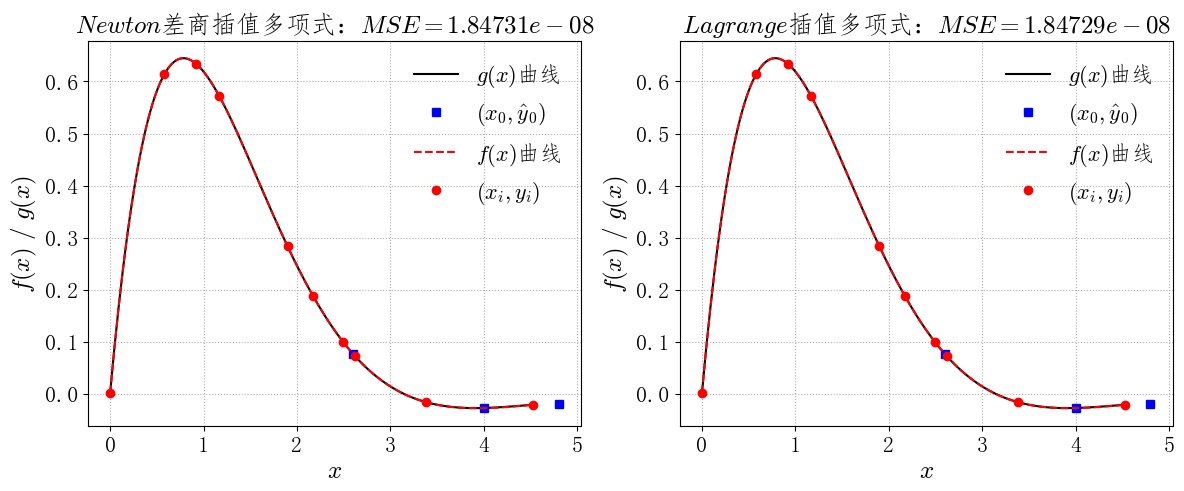

In [6]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@author:Lenovo
@file:test_newton_diff_quotient.py
@time:2021/08/29
"""
import numpy as np
import matplotlib.pyplot as plt
from interpolation_02.newton_diff_quotient_interp import NewtonDifferenceQuotient
from interpolation_02.lagrange_interpolation import LagrangeInterpolation

fh = lambda x: 2 * np.exp(-x) * np.sin(x)  # 函数模拟

np.random.seed(1)
# x = np.linspace(0, 2 * np.pi, 10, endpoint=True)
x = 0 + 2 * np.pi * np.random.rand(10)
x = np.sort(x)
print(x)
y = fh(x)
x0 = np.array([2.6, 4.0, 4.8])
nd = NewtonDifferenceQuotient(x, y)
nd.fit_interp()
# print(nd.diff_quot)  # 打印差商表
print(nd.poly_coefficient)
print(nd.coefficient_order)
y0 = nd.predict_x0(x0)
print("插值点的值：", y0, "，误差：", fh(x0) - y0)

plt.figure(figsize=(14, 5))
plt.subplot(121)
nd.plt_interpolation(x0, y0, fh=fh, is_show=False)
plt.subplot(122)
lag_iterp = LagrangeInterpolation(x, y)
lag_iterp.fit_interp()
y0 = lag_iterp.predict_x0(x0)
print(lag_iterp.poly_coefficient)
print(lag_iterp.coefficient_order)
print("插值点的值：", y0, "，误差：", fh(x0) - y0)
lag_iterp.plt_interpolation(x0, y0, fh, is_show=False)  # 可视化
plt.show()

0.00000e+00 6.39592e-01 -7.91664e-01 6.69509e-01 -4.44513e-01 2.25299e-01 -6.31525e-02 -3.11664e-02 6.92236e-02 -7.05579e-02 
6.39592e-01 -1.52072e-01 -1.22154e-01 2.24997e-01 -2.19213e-01 1.62147e-01 -9.43189e-02 3.80572e-02 -1.33432e-03 0.00000e+00 
4.87519e-01 -2.74227e-01 1.02842e-01 5.78346e-03 -5.70663e-02 6.78280e-02 -5.62617e-02 3.67229e-02 0.00000e+00 0.00000e+00 
2.13293e-01 -1.71384e-01 1.08626e-01 -5.12828e-02 1.07617e-02 1.15663e-02 -1.95389e-02 0.00000e+00 0.00000e+00 0.00000e+00 
4.19086e-02 -6.27586e-02 5.73428e-02 -4.05211e-02 2.23280e-02 -7.97255e-03 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 
-2.08501e-02 -5.41580e-03 1.68217e-02 -1.81931e-02 1.43555e-02 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 
-2.62659e-02 1.14059e-02 -1.37140e-03 -3.83764e-03 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 
-1.48600e-02 1.00345e-02 -5.20904e-03 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 
-4.82

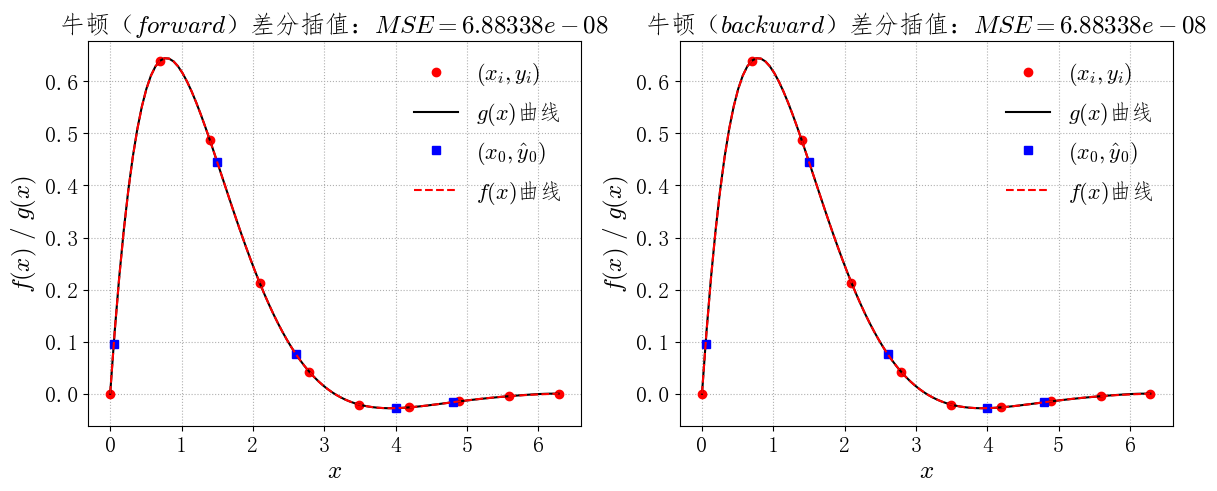

In [7]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@author:Lenovo
@file:test_newton_diff.py
@time:2021/08/29
"""
import numpy as np
import matplotlib.pyplot as plt
from interpolation_02.newton_difference_interpolation import NewtonDifferenceInterpolation

fh = lambda x: 2 * np.exp(-x) * np.sin(x)  # 函数模拟

x = np.linspace(0, 2 * np.pi, 10, endpoint=True)
y = fh(x)
x0 = np.array([0.05, 1.5, 2.6, 4.0, 4.8])
nd = NewtonDifferenceInterpolation(x, y)
nd.fit_interp()
for i in range(10):
    for j in range(10):
        print("%.5e" % nd.diff_val[i, j], end=" ")
    print()
# print(nd.polynomial)
print(nd.poly_coefficient)
# print(nd.coefficient_order)
y0 = nd.predict_x0(x0)
print("插值点的值：", y0, "，误差：", fh(x0) - y0)
# y_interp = nd.predict_x0(x)
# print(y_interp)
# print(y - y_interp)
print("=" * 60)
plt.figure(figsize=(14, 5))
plt.subplot(121)
nd.plt_interpolation(x0, y0, fh=fh, is_show=False)

nd = NewtonDifferenceInterpolation(x, y, diff_method="backward")
nd.fit_interp()
for i in range(10):
    for j in range(10):
        print("%.5e" % nd.diff_val[i, j], end=" ")
    print()
# print(nd.polynomial)
print(nd.poly_coefficient)
print(nd.coefficient_order)
y0 = nd.predict_x0(x0)
print("插值点的值：", y0, "，误差：", fh(x0) - y0)
# y_interp = nd.predict_x0(x)
# print(y_interp)
# print(y - y_interp)
plt.subplot(122)
nd.plt_interpolation(x0, y0, fh=fh, is_show=False)
plt.show()

## Hermite插值

In [8]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@file:hermite_interpolation.py
@IDE: PyCharm  Python: 3.9.7
@copyright: http://maths.xynu.edu.cn
"""

import numpy as np
import sympy
from interpolation_02.utils.interpolation_utils import InterpolationUtils


class HermiteInterpolation(InterpolationUtils):
    """
    埃尔米特插值：给定函数值及一阶导数值，继承InterpolationUtils
    """

    def __init__(self, x, y, dy):
        InterpolationUtils.__init__(self, x, y)  # 父类初始化
        self.dy = np.asarray(dy, dtype=np.float64)  # 给定数据点的一阶导数值

    def fit_interp(self):
        """
        生成埃尔米特插值多项式
        :return:
        """
        t = sympy.Symbol("t")  # 定义符号变量
        self.polynomial = 0.0  # 插值多项式实例化
        for i in range(self.n):
            h, a = 1.0, 0.0  # 根据公式2.8计算各项表达式
            for j in range(self.n):
                if j != i:
                    h *= (t - self.x[j]) ** 2 / (self.x[i] - self.x[j]) ** 2
                    a += 1 / (self.x[i] - self.x[j])
            self.polynomial += h * ((self.x[i] - t) *
                                    (2 * a * self.y[i] - self.dy[i]) + self.y[i])
        # 插值多项式特征
        InterpolationUtils.interpolation_polynomial(self, t)  # 调用父类实例方法

    def plt_interpolation(self, x0=None, y0=None, fh=None, is_show=True):
        """
        绘制插值多项式和插值点
        :return:
        """
        params = "$Hermite$", x0, y0, is_show
        InterpolationUtils.plt_interpolation(self, params, fh=fh)  # 调用父类实例方法


[-2.13256555113010, 22.7100113738733, -87.7961421623092, 128.566209194267, 22.4735134077025, -197.675315230956, 5.61595813760059, 194.358638409385, -4.16372823462282, -89.0716925563116, 11.2058748407389, 7.08950086873607]
[(11,), (10,), (9,), (8,), (7,), (6,), (5,), (4,), (3,), (2,), (1,), (0,)]
离散数据点(xk, yk)对应的多项式插值
 [-6.17022866 -6.16602479 -0.3132689  16.17832958  3.09395837  3.81329525]
离散数据点x插值的误差：
 [5.89440927e-05 5.88487835e-05 5.37641289e-05 5.02205479e-02
 3.73111366e-01 6.99948461e-01]


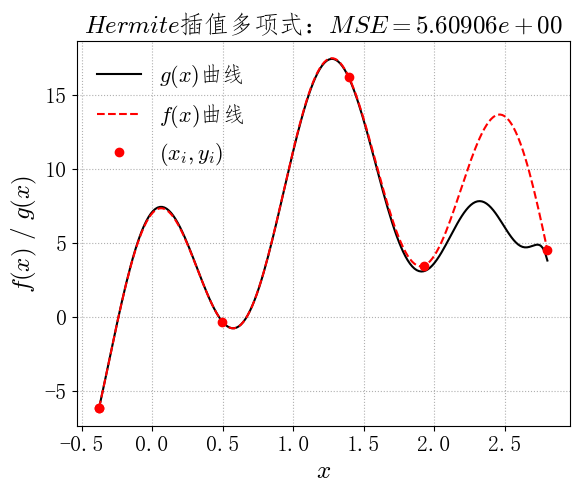

In [27]:
# -*- coding: UTF-8 -*-
import sys
sys.path.append(r'/home/ld/numerical-analysis-python/NumericalCalculationMethod')
"""
@author:Lenovo
@file:test_hermite.py
@time:2021/08/29
"""
import numpy as np

import matplotlib.pyplot as plt
from interpolation_02.hermite_interpolation import HermiteInterpolation
from interpolation_02.newton_difference_interpolation import NewtonDifferenceInterpolation

# fh = lambda x: 2 * np.exp(-x) * np.sin(x)  # 测试函数
# x = np.linspace(0, 2 * np.pi, 5, endpoint=True)  # 模拟五个点
# y = fh(x)
# dy = 2 * np.exp(-x) * (np.cos(x) - np.sin(x))  # 一阶导数值
# x0 = np.array([2.6, 4.0, 4.8])  # 求解指定点的插值
# hermite = HermiteInterpolation(x, y, dy)  # 埃尔米特插值
# hermite.fit_interp()  # 生成埃尔米特插值多项式
# print(hermite.poly_coefficient)  # 打印系数
# print(hermite.coefficient_order)  # 打印阶次
# y0 = hermite.predict_x0(x0)  # 求解指定点的插值
# print("插值点的值：", y0, "，误差：", fh(x0) - y0)
# plt.figure(figsize=(14, 5))
# plt.subplot(121)
# hermite.plt_interpolation(x0, y0, fh=fh, is_show=False)  # 埃尔米特插值可视化
# ndi = NewtonDifferenceInterpolation(x, y)
# ndi.fit_interp()
# plt.subplot(122)
# ndi.plt_interpolation(fh=fh, is_show=False)  # 牛顿前向差分插值可视化
# plt.show()

np.random.seed(42)
fh = lambda x: 11 * np.sin(x) + 7 * np.cos(5 * x)
# x = np.linspace(-1, 3, 6, endpoint=True)  # 模拟6个点
x = -1 + 4 * np.random.rand(6)
x = np.sort(x)
# print(x)
y = fh(x)  # 函数值
dy = 11 * np.cos(x) - 35 * np.sin(5 * x)
hermite = HermiteInterpolation(x, y, dy)  # 埃尔米特插值
hermite.fit_interp()  # 生成埃尔米特插值多项式
print(hermite.poly_coefficient)  # 打印系数
print(hermite.coefficient_order)  # 打印阶次
x0 = x
y0 = hermite.predict_x0(x)
print("离散数据点(xk, yk)对应的多项式插值\n", y0)
print("离散数据点x插值的误差：\n", abs(fh(x0) - y0))
plt.figure(figsize=(14, 5))
plt.subplot(121)
hermite.plt_interpolation(fh=fh, is_show=False)  # 埃尔米特插值可视化

# x = np.linspace(-1, 3, 10, endpoint=True)  # 模拟10个点
# # x = -1 + 4 * np.random.rand(10)
# # x = np.sort(x)
# # print(x)
# y = fh(x)  # 函数值
# dy = 11 * np.cos(x) - 35 * np.sin(5 * x)
# hermite = HermiteInterpolation(x, y, dy)  # 埃尔米特插值
# hermite.fit_interp()  # 生成埃尔米特插值多项式
# x0 = np.asarray([-0.9, -0.2, 1.5, 2.2, 2.7, 2.9])
# y0 = hermite.predict_x0(x0)
# print("离散数据点(xk, yk)对应的多项式插值\n", y0)
# print("离散数据点x插值的误差：\n", fh(x0) - y0)
# plt.subplot(122)
# hermite.plt_interpolation(fh=fh, x0=x0, y0=y0, is_show=False)  # 埃尔米特插值可视化

plt.show()

In [24]:
x

array([ 0.49816048,  2.80285723,  1.92797577,  1.39463394, -0.37592544,
       -0.37602192])